In this notebook, we will try to see the properties of our document vectors.

Let's load in our models

In [28]:
from gensim.models import Doc2Vec
models = [Doc2Vec.load('saved_doc2vec_models/Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)'), Doc2Vec.load('saved_doc2vec_models/Doc2Vec(dmc,d100,n5,w5,mc2,s0.001,t8)'), Doc2Vec.load('saved_doc2vec_models/Doc2Vec(dmm,d100,n5,w10,mc2,s0.001,t8)')]

In [29]:
from Doc2VecUtils import SentimentDocument
from Doc2VecUtils import read_labeled_corpus
from Doc2VecUtils import file_len
import os.path

In [30]:
dirname = 'data_small'
num_lines_test = file_len(os.path.join(dirname, 'test-pos.txt'))
num_lines_test += file_len(os.path.join(dirname, 'test-neg.txt'))

Let's see a 2-d representation of some of the document vectors in our Doc2Vec models.

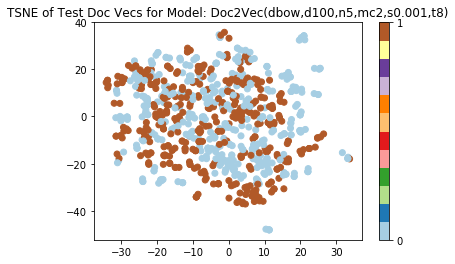

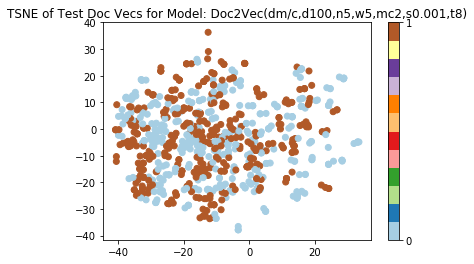

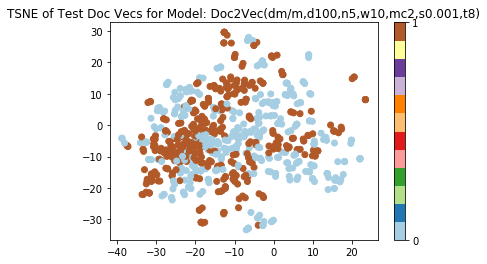

In [34]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.utils import resample
subsample = 1.0

for model in models:
    test_set = read_labeled_corpus(os.path.join(dirname, 'test-pos.txt'), os.path.join(dirname, 'test-neg.txt'), 'test')
    test_targets, test_regressors = zip(*[(doc.sentiment, model.infer_vector(doc.words)) 
                                          for doc in test_set])
#     test_targets, test_regressors = zip(*[(doc.sentiment, model.docvecs[doc.tags[0]]) 
#                                           for doc in test_set])
    test_targets, test_regressors = resample(test_targets, test_regressors, 
                                             n_samples = int(subsample * num_lines_test))
    embedded = TSNE(n_components=2).fit_transform(test_regressors)
    vis_x = embedded[:, 0]
    vis_y = embedded[:, 1]

    plt.scatter(vis_x, vis_y, c=test_targets, cmap=plt.cm.get_cmap("Paired"))
    plt.colorbar(ticks=range(2))
    plt.title("TSNE of Test Doc Vecs for Model: {}".format(str(model)))
    plt.show()
    test_targets = None
    test_regressors = None

In [42]:
import numpy as np
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn import svm
from sklearn.utils import resample
import pandas as pd

classifiers = [linear_model.LogisticRegression(), ensemble.RandomForestClassifier(), svm.SVC()]

def error_rate_for_model(test_model, train_set, test_set, classifier):
    """Report error rate on test_doc sentiments, using supplied model and train_docs"""
    train_targets, train_regressors = zip(*[(doc.sentiment, test_model.docvecs[doc.tags[0]]) for doc in train_set])
    train_targets, train_regressors = shuffle(train_targets, train_regressors)
    classifier.fit(train_regressors, train_targets)
    
    subsample = 1.0
    test_targets, test_regressors = zip(*[(doc.sentiment, test_model.infer_vector(doc.words)) for doc in test_set])
    test_targets, test_regressors = resample(test_targets, test_regressors, 
                                             n_samples = int(subsample * num_lines_test))  
    
    test_predictions = classifier.predict(test_regressors)
    len_predictions = len(test_predictions)
    corrects = sum(np.rint(test_predictions) == test_targets)
    errors = len_predictions - corrects
    error_rate = float(errors) / len_predictions
    return (error_rate, errors, len_predictions, classifier)

out_string = ""
results = []
for model in models:
    for classifier in classifiers:
        train_docs = read_labeled_corpus(os.path.join(dirname, 'train-pos.txt'), os.path.join(dirname, 'train-neg.txt'), 'train')
        test_docs = read_labeled_corpus(os.path.join(dirname, 'test-pos.txt'), os.path.join(dirname, 'test-neg.txt'), 'test')
        err, err_count, test_count, predictor = error_rate_for_model(model, train_docs, test_docs, classifier)
        results.append((1-err, test_count-err_count, test_count, predictor, model))
        out_string+="Accuracy: {0}; Error Count: {1}; Test Count {2}; Predictor: {3}; Model {4}\n".format(err, err_count, test_count, predictor, model)   
df = pd.DataFrame(data=results, columns=['Accuracy', 'Number Correct', 'Test Size', 'Classifier', 'Model'])
df

,Accuracy,Number Correct,Test Size,Classifier,Doc2Vec Model
0,0.509950,410,804,"LogisticRegression(C=1.0, class_weight=None, d...","Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)"
1,0.506219,407,804,"(DecisionTreeClassifier(class_weight=None, cri...","Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)"
2,0.460199,370,804,"SVC(C=1.0, cache_size=200, class_weight=None, ...","Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)"
3,0.509950,410,804,"LogisticRegression(C=1.0, class_weight=None, d...","Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t8)"
4,0.470149,378,804,"(DecisionTreeClassifier(class_weight=None, cri...","Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t8)"
5,0.493781,397,804,"SVC(C=1.0, cache_size=200, class_weight=None, ...","Doc2Vec(dm/c,d100,n5,w5,mc2,s0.001,t8)"
6,0.583333,469,804,"LogisticRegression(C=1.0, class_weight=None, d...","Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t8)"
7,0.546020,439,804,"(DecisionTreeClassifier(class_weight=None, cri...","Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t8)"
8,0.548507,441,804,"SVC(C=1.0, cache_size=200, class_weight=None, ...","Doc2Vec(dm/m,d100,n5,w10,mc2,s0.001,t8)"


In [43]:
print(out_string)

Accuracy: 0.4900497512437811; Error Count: 394; Test Count 804; Predictor: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False); Model Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)
Accuracy: 0.4937810945273632; Error Count: 397; Test Count 804; Predictor: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False); Model Doc2Vec(dbow,d100,n5,mc2,s0.001,t8)
Accuracy: 0.5398009950248757; Error Count: 434; Test Count 804; Predictor: SVC(C=1.0, cache_size=200, class_weight=N